<a href="https://colab.research.google.com/github/Gokul0Krishna/pytorchpractice/blob/master/attempt_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip "/content/synthetic.zip"
!unzip "/content/washer.v1i.multiclass.zip"
!unzip "/content/test.zip"
!unzip "/content/washer.v4i.multiclass.zip"

Archive:  /content/synthetic.zip
   creating: synthetic/
   creating: synthetic/nut/
  inflating: synthetic/nut/AKM_M10_1_10.png  
  inflating: synthetic/nut/AKM_M10_1_14.png  
  inflating: synthetic/nut/AKM_M10_1_15.png  
  inflating: synthetic/nut/AKM_M10_1_19.png  
  inflating: synthetic/nut/AKM_M10_1_20.png  
  inflating: synthetic/nut/AKM_M10_1_4.png  
  inflating: synthetic/nut/AKM_M10_1_5.png  
  inflating: synthetic/nut/AKM_M10_1_9.png  
  inflating: synthetic/nut/AKM_M12_1_10.png  
  inflating: synthetic/nut/AKM_M12_1_14.png  
  inflating: synthetic/nut/AKM_M12_1_15.png  
  inflating: synthetic/nut/AKM_M12_1_19.png  
  inflating: synthetic/nut/AKM_M12_1_20.png  
  inflating: synthetic/nut/AKM_M12_1_4.png  
  inflating: synthetic/nut/AKM_M12_1_5.png  
  inflating: synthetic/nut/AKM_M12_1_9.png  
  inflating: synthetic/nut/AKM_M14_1_10.png  
  inflating: synthetic/nut/AKM_M14_1_14.png  
  inflating: synthetic/nut/AKM_M14_1_15.png  
  inflating: synthetic/nut/AKM_M14_1_19.png  
 

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision import models,transforms
from torch.utils.data import DataLoader,Dataset

In [3]:
l=['washer','nut']
realimages=[]
reallabels=[]
for i in os.listdir("/content/washer.v4i.multiclass"):
  for j in os.listdir("/content/washer.v4i.multiclass/"+i):
    if j.endswith(".jpg") == True:
      realimages.append("/content/washer.v4i.multiclass/"+i+"/"+j)
      reallabels.append("washer")

for i in os.listdir("/content/washer.v1i.multiclass"):
    if i.endswith(".txt") == False:
      for j in os.listdir("/content/washer.v1i.multiclass/"+i):
        if j.endswith(".jpg") == True:
          realimages.append("/content/washer.v1i.multiclass/"+i+"/"+j)
          reallabels.append("washer")
a=0
for i in os.listdir("/content/test"):
  for j in os.listdir("/content/test/"+i):
      if a>250:
          break
      realimages.append("/content/test/"+i+"/"+j)
      reallabels.append("nut")
      a+=1

In [4]:
syntheticimages=[]
syntheticlabels=[]
for i in os.listdir("/content/synthetic"):
  for j in os.listdir("/content/synthetic/"+i):
      syntheticimages.append("/content/synthetic/"+i+"/"+j)
      syntheticlabels.append(i)

In [5]:
dfs=pd.DataFrame({'X':syntheticimages,'Y':syntheticlabels})
dfs=pd.get_dummies(dfs,columns=['Y'],dtype=float)
dfs.columns = dfs.columns.str.replace("Y_", "")

dfr=pd.DataFrame({'X':realimages,'Y':reallabels})
dfr=pd.get_dummies(dfr,columns=['Y'],dtype=float)
dfr.columns = dfr.columns.str.replace("Y_", "")

In [6]:
class customdataset(Dataset):
    def __init__(self,x,y,transform=None):
        self.x=x
        self.y=y
        self.transform=transform

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index):
        imgpath=self.x.iloc[index]
        if self.transform:
            image=Image.open(imgpath).convert("RGB")
            image=self.transform(image)
        label_row = self.y.iloc[index, 0:2]
        label_tensor = torch.tensor(label_row.values.astype(np.float32))
        label_index = torch.argmax(label_tensor).item()

        return image,label_index

In [7]:
synthetic_train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomRotation(30),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [8]:
testmodel = models.densenet201(pretrained=True)
for param in testmodel.parameters():  # Freeze all layers
    param.requires_grad = False
testmodel.classifier = nn.Linear(testmodel.classifier.in_features, 2)  # Unfreeze classifier
for param in testmodel.classifier.parameters():
    param.requires_grad = True

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 87.1MB/s]


In [9]:
from sklearn.model_selection import train_test_split
xstrain, xstest,ystrain,ystest = train_test_split(dfs['X'],dfs[l],random_state=42, test_size=0.2)
traindataset=customdataset(x=xstrain,y=ystrain,transform=synthetic_train_transforms)
valdataset=customdataset(x=xstest,y=ystest,transform=synthetic_train_transforms)

trainloader=DataLoader(traindataset,batch_size=64,shuffle=True)
valloader=DataLoader(valdataset,batch_size=64,shuffle=True,)

In [10]:
testmodel.classifier = torch.nn.Linear(testmodel.classifier.in_features, 2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params': testmodel.classifier.parameters(), 'lr': 0.001},  # Higher LR for new layers
    {'params': testmodel.features.parameters(), 'lr': 0.00001}    # Lower LR for pretrained
], weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
testmodel = testmodel.to(device)

In [11]:
num_epochs = 2

for epoch in range(num_epochs):
    testmodel.train()
    trunningloss,vrunningloss=0.0,0.0
    ttotal,vtotal = 0,0
    tacc,vacc=0.0,0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = testmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        trunningloss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class
        ttotal += labels.size(0)
        tacc += (predicted == labels).sum().item()


    testmodel.eval()
    with torch.no_grad():
      for inputs, labels in valloader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = testmodel(inputs)
          loss = criterion(outputs, labels)
          vrunningloss += loss.item()

          _, predicted = torch.max(outputs.data, 1)  # Get predicted class
          vtotal += labels.size(0)
          vacc += (predicted == labels).sum().item()

    print("="*20)
    print(f"""Epoch {epoch+1}
          train
          Loss: {trunningloss/len(trainloader)}
          Accuracy: {tacc*100/ttotal}
          val
          Loss: {vrunningloss/len(valloader)}
          Accuracy: {vacc*100/vtotal}
          """)

Epoch 1
          train
          Loss: 0.33730546773100895
          Accuracy: 89.1332895600788
          val
          Loss: 0.19405085345109305
          Accuracy: 94.48818897637796
          
Epoch 2
          train
          Loss: 0.16706575934464732
          Accuracy: 94.8456992777413
          val
          Loss: 0.1369241556773583
          Accuracy: 95.53805774278216
          


In [12]:
real_train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
xstrain, xstest,ystrain,ystest = train_test_split(dfs['X'],dfs[l],random_state=42, test_size=0.3)
straindataset=customdataset(x=xstrain,y=ystrain,transform=synthetic_train_transforms)
svaldataset=customdataset(x=xstest,y=ystest,transform=synthetic_train_transforms)

xrtrain, xrtest,yrtrain,yrtest = train_test_split(dfr['X'],dfr[l],random_state=42, test_size=0.3)
rtraindataset=customdataset(x=xrtrain,y=yrtrain,transform=real_train_transforms)
rvaldataset=customdataset(x=xrtest,y=yrtest,transform=real_train_transforms)


In [14]:
mixedtraindataset = torch.utils.data.ConcatDataset([straindataset, rtraindataset])
# mixedtrainloader = DataLoader(mixedtraindataset, batch_size=64, shuffle=True)

mixedvaldataset = torch.utils.data.ConcatDataset([svaldataset, rvaldataset])
mixedvalloader = DataLoader(mixedvaldataset, batch_size=32, shuffle=False)


In [15]:
real_weight = 3.0  # Higher weight for real data
synthetic_weight = 1.0
weights = torch.tensor([synthetic_weight] * len(straindataset) + [real_weight] * len(rtraindataset))
sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))
tweighted_mixed_loader = DataLoader(mixedtraindataset, batch_size=32, sampler=sampler)

# weights = torch.tensor([synthetic_weight] * len(svaldataset) + [real_weight] * len(rvaldataset))
# sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))
# vweighted_mixed_loader = DataLoader(mixedvaldataset, batch_size=32, sampler=sampler)

In [16]:
for param in testmodel.features.parameters():
    param.requires_grad = False
class_weights = torch.tensor([1.0, 3.0])
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam([
    {'params': testmodel.classifier.parameters(), 'lr': 0.001},
    {'params': testmodel.features.denseblock4.parameters(), 'lr': 0.0001},
    {'params': testmodel.features.denseblock3.parameters(), 'lr': 0.00001}
], weight_decay=1e-5)

In [17]:
num_epochs = 2

for epoch in range(num_epochs):
    testmodel.train()
    trunningloss,vrunningloss=0.0,0.0
    ttotal,vtotal = 0,0
    tacc,vacc=0.0,0.0
    for inputs, labels in tweighted_mixed_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = testmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        trunningloss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class
        ttotal += labels.size(0)
        tacc += (predicted == labels).sum().item()


    testmodel.eval()
    with torch.no_grad():
      for inputs, labels in mixedvalloader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = testmodel(inputs)
          loss = criterion(outputs, labels)
          vrunningloss += loss.item()

          _, predicted = torch.max(outputs.data, 1)  # Get predicted class
          vtotal += labels.size(0)
          vacc += (predicted == labels).sum().item()

    print("="*20)
    print(f"""Epoch {epoch+1}
          train
          Loss: {trunningloss/len(tweighted_mixed_loader)}
          Accuracy: {tacc*100/ttotal}
          val
          Loss: {vrunningloss/len(mixedvalloader)}
          Accuracy: {vacc*100/vtotal}
          """)

Epoch 1
          train
          Loss: 0.13057842231110522
          Accuracy: 93.33554376657825
          val
          Loss: 0.09391165856362843
          Accuracy: 97.14064914992272
          
Epoch 2
          train
          Loss: 0.08377819276953999
          Accuracy: 96.35278514588859
          val
          Loss: 0.07157558328812806
          Accuracy: 97.52704791344668
          
Epoch 3
          train
          Loss: 0.07867774369293137
          Accuracy: 96.5185676392573
          val
          Loss: 0.06355674157100843
          Accuracy: 97.75888717156106
          


In [18]:
real_train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [19]:
rtraindataset=customdataset(x=xrtrain,y=yrtrain,transform=real_train_transforms)
rvaldataset=customdataset(x=xrtest,y=yrtest,transform=real_train_transforms)
mixedtrainloader = DataLoader(mixedtraindataset, batch_size=16, shuffle=True)
mixedvalloader = DataLoader(mixedvaldataset, batch_size=16, shuffle=True)

In [20]:
for param in testmodel.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(testmodel.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

In [21]:
num_epochs = 1

for epoch in range(num_epochs):
    testmodel.train()
    trunningloss,vrunningloss=0.0,0.0
    ttotal,vtotal = 0,0
    tacc,vacc=0.0,0.0
    for inputs, labels in mixedtrainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = testmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        trunningloss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class
        ttotal += labels.size(0)
        tacc += (predicted == labels).sum().item()


    testmodel.eval()
    with torch.no_grad():
      for inputs, labels in mixedvalloader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = testmodel(inputs)
          loss = criterion(outputs, labels)
          vrunningloss += loss.item()

          _, predicted = torch.max(outputs.data, 1)  # Get predicted class
          vtotal += labels.size(0)
          vacc += (predicted == labels).sum().item()

    print("="*20)
    print(f"""Epoch {epoch+1}
          train
          Loss: {trunningloss/len(mixedtrainloader)}
          Accuracy: {tacc*100/ttotal}
          val
          Loss: {vrunningloss/len(mixedvalloader)}
          Accuracy: {vacc*100/vtotal}
          """)

Epoch 1
          train
          Loss: 0.06267423046476862
          Accuracy: 98.07692307692308
          val
          Loss: 0.017826623800728057
          Accuracy: 99.53632148377125
          
Epoch 2
          train
          Loss: 0.039521451711176686
          Accuracy: 98.80636604774536
          val
          Loss: 0.007754784310236573
          Accuracy: 99.69088098918084
          
Epoch 3
          train
          Loss: 0.01820996566921985
          Accuracy: 99.60212201591511
          val
          Loss: 0.0031204879934968494
          Accuracy: 99.9227202472952
          


In [23]:
!unzip "/content/finaltest.zip"

Archive:  /content/finaltest.zip
   creating: finaltest/
  inflating: finaltest/10_jpg.rf.2746378b9f91a509adb2df2a5d70d7cf.jpg  
  inflating: finaltest/26_jpg.rf.74a33bc5714c4d679aeb9c1b137c0064.jpg  
  inflating: finaltest/35_jpg.rf.d1028936f944a1cf8ac0995c24bd6571.jpg  
  inflating: finaltest/_classes.csv  


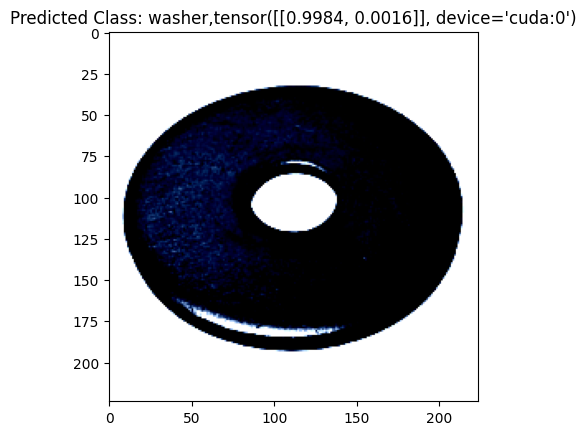

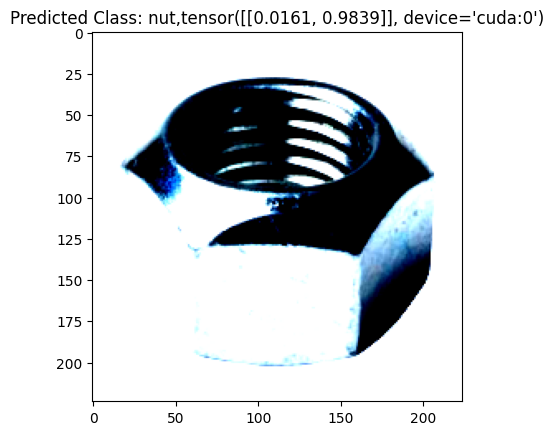

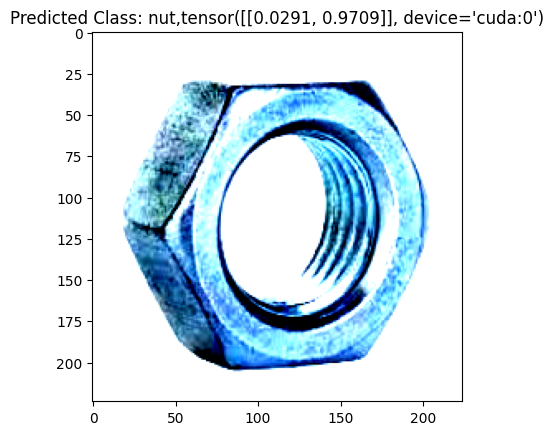

In [25]:

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
import cv2
from matplotlib import pyplot as plt
testmodel.eval()
for i in os.listdir("/content/finaltest"):
  if i.endswith(".jpg"):
    img=cv2.imread("/content/finaltest/"+i)
    # cv2_imshow(img)
    with torch.no_grad():
      img=Image.open("/content/finaltest/"+i).convert("RGB")
      img=preprocess(img)
      img = img.unsqueeze(0)
      img = img.to(device) # Move input to the same device as the model
      ouptut=testmodel(img)
      prob=torch.softmax(ouptut,dim=1)
      predicted_class = torch.argmax(prob).item()
      img=img.squeeze(0).permute(1,2,0).cpu().numpy()
      plt.imshow(img)
      plt.title(f"Predicted Class: {l[predicted_class]},{prob}")
      plt.show()

In [26]:
torch.save(testmodel, 'classifier.pth')

In [27]:
torch.save(testmodel.state_dict(), 'classifier_state_dict.pth')